In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, BertTokenizer
import re
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from pylab import rcParams
import pickle

In [3]:
jtplot.style()

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#raw_data_path = 'data/evaluation-final.csv'
#raw_data_path = 'annotation-final-sorted-filtered.csv'
raw_data_path = 'annotation-final-baseline-rev.csv'

df = pd.read_csv(raw_data_path)

In [6]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    # Quitamos símbolos que no aportan información
    replacements = (
        ("_", " "), ("x000D", " "), ("-", " "),
        ("[", ""), ("]", ""), ("'", ""), ("#", " "), ("*", "")
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    #output = re.sub(r'(?is)\s+', ' ', output)
    output = re.sub(r'[0-9]', '', output)  # Quitar números
    output = re.sub(r'\t+', ' ', output)  # Cambiar tabulaciones por espacios
    output = re.sub(r'\n{2,}', '\n', output)  # Cambiar varios saltos de línea seguidos por uno solo
    output = re.sub(r' {2,}', ' ', output)  # Cambiar varios espacios seguidos por uno solo

    return output.strip()

def clean_labels(label):
    return "unknown" if str(label) == "None" else label

In [7]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    replacements = (
      ("“", ''), ("”", ''), ("//", ""), ("«", ''), ("»", ''), (",", ''),
      (";", ''), (".", ''),
        # ("?", ''), ("¿", ''), ("¡", ''), ("!", ''), ("-", ' '),
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    
    #output = re.sub(r'\t+', ' ', output)
    #output = re.sub(r'\n{2,}', '', output)
    #output = re.sub(r'^\s+\*.*\n', '', output)
    
    output = re.sub(r'[0-9]', '', output)  # Quitar números
    output = re.sub(r'\t+', ' ', output)  # Cambiar tabulaciones por espacios
    output = re.sub(r'\n{2,}', '\n', output)  # Cambiar varios saltos de línea seguidos por uno solo
    #output = re.sub(r'\n', ' <CR> ', output)  # Cambiar saltos de línea por etiqueta <CR>
    output = re.sub(r' {2,}', ' ', output)  # Cambiar varios espacios seguidos por uno solo
    return output.strip()


def clean_labels(label):
    return "unknown" if str(label) == "None" else label

In [8]:
df

,Stanza_text,ST_Correct,Title,Author,Year,Copyrighted,Tipo de rima,Información métrica,Unnamed: 8
0,"La catedral de Barcelona dice: \nSe levantan, ...",None,?,Miguel de Unamuno,1936,no,Sin rima,NaN,NaN
1,"No estás ya aquí. Lo que veo\nde ti, cuerpo, e...",None,?,Pedro Salinas,1951,si,Sin rima,NaN,NaN
2,"Perdóname, Fray luan, si profano tu lira\nun t...",None,Lámparas de fuego,Gerardo de Diego,1987,si,Sin rima,NaN,NaN
3,"Es el sol un bello lucero,\nque cada mañana me...",None,De su libro: Amor en un suspiro,Vicente Devesa Llobel,?,si,Sin rima,NaN,NaN
4,"Como me gustaría poder ser voz,\ncomo me gusta...",None,De su libro: Amor en un suspiro,Vicente Devesa Llobel,?,si,Sin rima,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5000,"Verdugos de ideales afligieron la tierra,\nen ...",terceto_monorrimo,Canto de esperanza,Rubén Darío,1916,No,Consonante,14A 14A 14A,NaN
5001,"¡Oh, Señor Jesucristo! ¡Por qué tardas, qué es...",terceto_monorrimo,Canto de esperanza,Rubén Darío,1916,No,Consonante,14A 14A 13A,NaN
5002,Surge de pronto y vierte la esencia de la vida...,terceto_monorrimo,Canto de esperanza,Rubén Darío,1916,No,Consonante,14A 14A 14A,NaN
5003,"Ven, Señor, para hacer la gloria de Ti mismo;\...",terceto_monorrimo,Canto de esperanza,Rubén Darío,1916,No,Consonante,13A 14A 13A,NaN


In [9]:
df["n_verses"] = df["Stanza_text"].apply(lambda x: x.count('\n')+1)

In [10]:
df.loc[df['n_verses'] == 1]

,Stanza_text,ST_Correct,Title,Author,Year,Copyrighted,Tipo de rima,Información métrica,Unnamed: 8,n_verses


In [11]:
df['n_verses'] = df['n_verses'].apply(lambda x: 5 if x==1 else x)
df['n_verses'] = df['n_verses'].apply(lambda x: 2 if x==1 else x)

## Load Dataset

In [12]:
def prepare_data():
    df_out = pd.DataFrame()
    df = (pd
        .read_csv(raw_data_path)
        .rename(columns={"Stanza_text": "text", "ST_Correct": "stanza"})
        .assign(
            text=lambda x: x["text"].apply(clean_text),
            stanza=lambda x: x["stanza"].apply(clean_labels),
        )
    )
    label_encoder = LabelEncoder()
    df_out["text"] = df["text"]
    df_out["label"] = label_encoder.fit_transform(df["stanza"])
    return df_out, label_encoder

In [ ]:
df_full, label_encoder = prepare_data()

In [ ]:
df_full["n_verses"] = df["n_verses"]

In [ ]:
df["n_verses"].nunique()

In [13]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
#train_df, test_df = train_test_split(df_full,stratify=df_full["label"], test_size=0.2, random_state=4242)
#train_df, test_df = train_test_split(df_full,stratify=df_full["n_verses"], test_size=0.2, random_state=4242)
X_test = list(test_df['text'])
y_test = list(test_df['label'])
#y_test = list(test_df['n_verses'])

In [14]:
#train_df.to_csv(r'train_df.csv', index = False)
#test_df.to_csv(r'test_df.csv', index = False)

In [15]:
X = list(train_df['text'])
y = list(train_df['label'])
#y = list(train_df['n_verses'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y,stratify=train_df["label"], test_size=0.2, random_state=4242)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y,stratify=train_df["label"], test_size=0.2, random_state=4242)

## Embeddings

In [16]:
#BERT_NAME = 'bert-base-multilingual-cased'
BERT_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
#BERT_NAME = 'mrm8488/bert-spanish-cased-finetuned-pos'
#BERT_NAME = 'xlm-roberta-large-finetuned-conll02-spanish'

In [17]:
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

tokenizer = BertTokenizer.from_pretrained(BERT_NAME)

<AxesSubplot:>

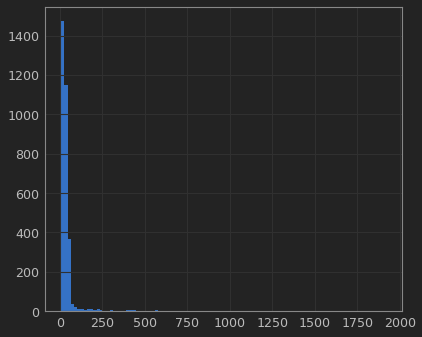

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 100)

In [19]:
USE_EVAL = True

In [20]:
MAX_LENGTH = 300
STRIDE_LENGTH = 10
# tokenize and encode sequences in the training set
if USE_EVAL:
    # tokenize and encode sequences in the validation set
    tokens_val = tokenizer.batch_encode_plus(
        X_valid,
        padding=True,
        max_length=MAX_LENGTH,
        truncation=True,
        return_overflowing_tokens=True,
        stride=STRIDE_LENGTH
    )
    tokens_train = tokenizer.batch_encode_plus(
    X_train,
    padding=True,
    max_length=MAX_LENGTH,
    truncation=True,
    return_overflowing_tokens=True,
    stride=STRIDE_LENGTH
    )
else: 
    tokens_train = tokenizer.batch_encode_plus(
    X,
    padding=True,
    max_length=MAX_LENGTH,
    truncation=True,
    return_overflowing_tokens=True,
    stride=STRIDE_LENGTH
    )
    
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test,
    padding=True,
    max_length=MAX_LENGTH,
    truncation=True,
    return_overflowing_tokens=True,
    stride=STRIDE_LENGTH
)

In [21]:
if USE_EVAL:
    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(y_train)
    train_y = nn.functional.pad(input=train_y, pad=(0, train_mask.size()[0]-train_y.size()[0]), mode='constant', value=0)

    val_seq = torch.tensor(tokens_val['input_ids'])
    val_mask = torch.tensor(tokens_val['attention_mask'])
    val_y = torch.tensor(y_valid)
    val_y = nn.functional.pad(input=val_y, pad=(0, val_mask.size()[0]-val_y.size()[0]), mode='constant', value=0)
else:
    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(y)
    train_y = nn.functional.pad(input=torch.tensor(train_y), pad=(0, train_mask.size()[0]-train_y.size()[0]), mode='constant', value=0)
    


In [22]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test)
test_y = nn.functional.pad(input=test_y, pad=(0, test_mask.size()[0]-test_y.size()[0]), mode='constant', value=0)


In [23]:
pickle.dump(test_y, open("test_y.p", "wb"))

In [ ]:
#define a batch size
batch_size = 16 #150

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

if USE_EVAL:
    # wrap tensors
    val_data = TensorDataset(val_seq, val_mask, val_y)
    # sampler for sampling the data during training
    val_sampler = SequentialSampler(val_data)
    # dataLoader for validation set
    val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,
                                                       len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)

            # Report progress.
            print(
                '  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [17]:
class BERT_lstm(nn.Module):

    def __init__(self):
        super(BERT_lstm, self).__init__()
        self.bert = AutoModel.from_pretrained(BERT_NAME)
        self.lstm = nn.LSTM(768, 768, batch_first=True, num_layers=3, dropout=0.2, bidirectional=True)
        self.linear1 = nn.Linear(768*2, 300)
        self.linear2 = nn.Linear(300, 46)

    def forward(self, sent_id, mask):
        self.bert.config.return_dict=False
        self.bert.config.output_hidden_states=True
        with torch.no_grad():  # disable gradient calculation to freeze the model
            # pass the inputs to the model
            cls_emb, pool, hidden_states, *_ = self.bert(sent_id, attention_mask=mask)
        output, (h_n, c_n) = self.lstm(cls_emb)
        out = self.linear1(output)
        out = torch.sum(out, 1).squeeze(1)
        out = nn.functional.gelu(out)
        out = self.linear2(out)
        return out

In [ ]:
model = BERT_lstm()
model = model.to(device)

In [ ]:
#model.bert.config.

In [ ]:
# define the optimizer
#optimizer = AdamW(model.parameters(), lr=3e-5)
optimizer = AdamW(model.parameters(), lr=0.0001)
#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# push to GPU
weights = weights.to(device)
# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 
# number of training epochs
epochs = 5

In [ ]:
# initial loss = infinite
best_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    if USE_EVAL:
        valid_loss, _ = evaluate()
        # save best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')
    else:
        # save best model
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), 'saved_weights.pt')
        
    train_losses.append(train_loss)
    if USE_EVAL:
        valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    if USE_EVAL:
        print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights_bert.pt'
model.load_state_dict(torch.load(path))

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [19]:
model = BERT_lstm()
path = 'saved_weights_bert.pt'
model.load_state_dict(torch.load(path))
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

In [23]:
pickle.dump(preds, open("bert_preds.p", "wb"))

In [25]:
pickle.dump(test_seq, open("test_seq.p", "wb"))

In [26]:
pickle.dump(test_mask, open("test_mask.p", "wb"))

In [24]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds, zero_division=0, digits = 4))

              precision    recall  f1-score   support

           0     0.3333    0.0690    0.1143        29
           1     0.5000    0.1818    0.2667        11
           2     0.7500    0.6429    0.6923        14
           3     0.4500    0.6429    0.5294        14
           4     0.2766    0.4643    0.3467        28
           5     0.0000    0.0000    0.0000         2
           6     0.5000    0.1429    0.2222        28
           7     0.4667    0.2500    0.3256        28
           8     0.4444    0.8889    0.5926        27
           9     0.4167    0.1923    0.2632        26
          10     0.3333    0.0769    0.1250        26
          11     0.1277    1.0000    0.2264        12
          12     0.3478    0.5333    0.4211        15
          13     0.5000    0.7857    0.6111        14
          14     0.2833    0.6296    0.3908        27
          15     0.2727    0.5000    0.3529        12
          16     0.6364    0.2500    0.3590        28
          17     0.6471    

In [ ]:
print(classification_report(test_y, preds, zero_division=0, digits = 2))

In [ ]:
rcParams['figure.figsize'] = 20, 10
plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
if USE_EVAL:
    plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
leg = plt.legend();

In [ ]:
label_encoder.classes_

In [ ]:
label_encoder.inverse_transform([12])